<a href="https://colab.research.google.com/github/escuccim/vaegan-pytorch/blob/master/VAEGAN_Implementation_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Sun Dec  1 06:43:56 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt, colors
%matplotlib inline
import zipfile
import os
import matplotlib.animation as animation
import torchvision.utils as vutils
import numpy as np
import random
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
import progressbar
from torchvision.utils import make_grid

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'gan-faces'

!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
if not os.path.exists("net.pt"):
  !gsutil cp gs://{bucket_name}/net.pt ./net.pt 

Copying gs://gan-faces/net.pt...
| [1 files][301.1 MiB/301.1 MiB]                                                
Operation completed over 1 objects/301.1 MiB.                                    


In [0]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

if not os.path.exists("wiki_images_good.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./ 
  zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
  zip_ref.extractall('data/wiki_images')
  zip_ref.close()  

# if not os.path.exists("celeb_a_good.zip"):
# #   !kaggle datasets download -d jessicali9530/celeba-dataset
#   !gsutil cp gs://{bucket_name}/celeb_a_good.zip ./celeb_a_good.zip
#   zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
#   zip_ref.extractall('data/images/celeb_a')
#   zip_ref.close()

if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images/training')
  zip_ref.close()
  
if not os.path.exists("imdb_crop_good.zip"):  
  !gsutil cp gs://{bucket_name}/imdb_crop_good.zip ./imdb_crop_good.zip
  zip_ref = zipfile.ZipFile('imdb_crop_good.zip', 'r')
  zip_ref.extractall('data/images/imdb')
  zip_ref.close()

# if not os.path.exists("crop_part1_good.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_good.zip ./crop_part1_good.zip
#   zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
#   zip_ref.extractall('data/images/crop_parta')
#   zip_ref.close()   

Copying gs://gan-faces/celeba-dataset.zip...
| [1 files][  1.2 GiB/  1.2 GiB]   17.7 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      
Copying gs://gan-faces/wiki_images_good.zip...
- [1 files][ 94.7 MiB/ 94.7 MiB]                                                
Operation completed over 1 objects/94.7 MiB.                                     
--2019-12-01 06:46:09--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.156.13
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.156.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 955202 (933K) [application/zip]
Saving to: ‘Training_Pictures.zip’

Training_Pictures.z 100%[===================>] 932.81K   730KB/s    in 1.3s    

2019-12-01 06:46:11 (730 KB/s) - ‘Training_Pictures.zip’ saved [955202/955202]

Copying gs://gan-fa

In [0]:
if not os.path.exists("crop_part1_good.zip"):
  !gsutil cp gs://pneumonia/crop_part1_good.zip ./crop_part1_good.zip
  zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
  zip_ref.extractall('data/test_images/crop_parta')
  zip_ref.close()   

# !gsutil cp crop_part1_good.zip  gs://{bucket_name}/crop_part1_good.zip 

Copying gs://pneumonia/crop_part1_good.zip...
| [1 files][ 49.4 MiB/ 49.4 MiB]                                                
Operation completed over 1 objects/49.4 MiB.                                     


In [0]:
# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        if out:
            ten = self.conv(ten)
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            ten = self.bn(ten)
            ten = F.relu(ten, True)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = self.bn(ten)
        ten = F.relu(ten, True)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=3, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(4):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=8 * 8 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(True))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Linear(in_features=1024, out_features=z_size)
        self.l_var = nn.Linear(in_features=1024, out_features=z_size)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=8 * 8 * size, bias=False),
                                nn.BatchNorm1d(num_features=8 * 8 * size,momentum=0.9),
                                nn.ReLU(True))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size))
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = ten.view(len(ten), -1, 8, 8)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=3,recon_level=3):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=64))
        self.size = 64
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=128))
        self.size = 128
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        self.size = 256
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=512))
        self.size = 512
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=8 * 8 * self.size, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),

        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, ten,ten_original,ten_sampled):

        ten = torch.cat((ten, ten_original,ten_sampled), 0)

        for i, lay in enumerate(self.conv):
            # we take the 9th layer as one of the outputs
            if i == self.recon_levl:
                ten, layer_ten = lay(ten, True)
                # we need the layer representations just for the original and reconstructed,
                # flatten, because it's a convolutional shape
                layer_ten = layer_ten.view(len(layer_ten), -1)
            else:
                ten = lay(ten)

        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        return layer_ten, self.sigmoid(ten)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)


class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=3):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        self.encoder = Encoder(z_size=self.z_size)
        self.decoder = Decoder(z_size=self.z_size, size=self.encoder.size)
        self.discriminator = Discriminator(channel_in=3,recon_level=recon_level)
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/numpy.sqrt(numpy.prod(m.weight.shape[1:]))
                    scale /=numpy.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform_(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, ten, gen_size=10, output_samples=False):
        if self.training:
            # save the original images
            ten_original = ten
            # encode
            mus, log_variances = self.encoder(ten)
            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            # sample from a gaussian

            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            # shift and scale using the means and variances

            ten = ten_from_normal * variances + mus
            # decode the tensor
            ten = self.decoder(ten)
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            ten_from_normal = self.decoder(ten_from_normal)
            #discriminator
            ten_layer,ten_class = self.discriminator(ten,ten_original,ten_from_normal)

            return ten, ten_class, ten_layer, mus, log_variances

        else:
            if ten is None:
                # just sample and decode
                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                
                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                
                # we'll just use the mean, ignoring the variance
                ten = mus

                # decode the tensor
                ten = self.decoder(torch.cat((ten, ten_from_normal), 0))
            return ten

    def __call__(self, *args, **kwargs):
        return super(VaeGan, self).__call__(*args, **kwargs)

    @staticmethod
    def loss(ten_original, ten_predicted, layer_original, layer_predicted,layer_sampled, labels_original,
             labels_predicted,labels_sampled, mus, variances):
        """
        :param ten_original: original images
        :param ten_predicted:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predicted.view(len(ten_predicted), -1)) ** 2
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        # mse between intermediate layers for both
        mse_1 = torch.sum(0.5*(layer_original - layer_predicted) ** 2, 1)
        mse_2 = torch.sum(0.5*(layer_original - layer_sampled) ** 2, 1)
        # bce for decoder and discriminator for original, sampled and reconstructed
        # the only excluded is the bce_gen_original

        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)
        bce_dis_recon = -torch.log(1 - labels_predicted+ 1e-3)

        #bce_gen_original = -torch.log(1-labels_original + 1e-3)
        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        bce_gen_recon = -torch.log(labels_predicted+ 1e-3)
        '''
        
        bce_gen_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.ones_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_gen_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.ones_like(labels_sampled.data).cuda(), requires_grad=False))
        bce_dis_original = nn.BCEWithLogitsLoss(size_average=False)(labels_original,
                                        Variable(torch.ones_like(labels_original.data).cuda(), requires_grad=False))
        bce_dis_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.zeros_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_dis_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.zeros_like(labels_sampled.data).cuda(), requires_grad=False))
        '''
        return nle, kl, mse_1,mse_2,\
               bce_dis_original, bce_dis_sampled,bce_dis_recon,bce_gen_sampled,bce_gen_recon

In [0]:
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [0]:
import numpy
import os
from torch.utils.data import Dataset, DataLoader
import cv2
from skimage import filters,transform
numpy.random.seed(5)

def _resize(img):
    rescale_size = 64
    bbox = (40, 218 - 30, 15, 178 - 15)
    img = img[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    # Smooth image before resize to avoid moire patterns
    scale = img.shape[0] / float(rescale_size)
    sigma = numpy.sqrt(scale) / 2.0
    img = filters.gaussian(img, sigma=sigma, multichannel=True)
    img = transform.resize(img, (rescale_size, rescale_size, 3), order=3,mode="constant")
    img = (img*255).astype(numpy.uint8)
    return img

class CELEBA(Dataset):
    """
    loader for the CELEB-A dataset
    """

    def __init__(self, data_folder):
        #len is the number of files
        self.len = len(os.listdir(data_folder))
        #list of file names
        self.data_names = [os.path.join(data_folder, name) for name in sorted(os.listdir(data_folder))]
        #data_all
        #if "train" in data_folder:
        #    self.data = numpy.load("/home/lapis/Desktop/full_train.npy")
        #else:
        #    self.data = numpy.load("/home/lapis/Desktop/full_test.npy")

        self.len = len(self.data_names)
    def __len__(self):
        return self.len

    def __iter__(self):
        return self

    def __getitem__(self, item):
        """
        :param item: image index between 0-(len-1)
        :return: image
        """
        #load image,crop 128x128,resize,transpose(to channel first),scale (so we can use tanh)
        data = cv2.cvtColor(cv2.imread(self.data_names[item]), cv2.COLOR_BGR2RGB)

        data = _resize(data)

        # CHANNEL FIRST
        data = data.transpose(2, 0, 1)
        # TANH
        data = data.astype("float32") / 127.5 - 1.0

        return (data.copy(),data.copy())


class CELEBA_SLURM(Dataset):
    """
    loader for the CELEB-A dataset
    """

    def __init__(self, data_folder):
        #open the file
        self.file = open(os.path.join(data_folder,"images/img_align_celeba"),"rb")
        #get len
        self.len = int(os.path.getsize(os.path.join(data_folder,"images"))/(64*64*3))
    def __len__(self):
        return self.len

    def __iter__(self):
        return self

    def __getitem__(self, item):
        """
        :param item: image index between 0-(len-1)
        :return: image
        """
        offset = item*3*64*64
        self.file.seek(offset)
        data = numpy.fromfile(self.file, dtype=numpy.uint8, count=(3 * 64 * 64))
        data = numpy.reshape(data, newshape=(3, 64, 64))
        data = data.astype("float32") / 127.5 - 1.0
        return (data.copy(),data.copy())

In [0]:
batch_size = BATCH_SIZE = 96
data_path = "data/images"
image_size = (128,128)

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=2, translate=(0.05,0.05), scale=(0.95,1.05), shear=2, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.RandomResizedCrop(image_size, scale=(0.9, 1.10)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.05)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=192,
    num_workers=2,
    shuffle=True
)

In [0]:
z_size = 256
recon_level = 4
decay_lr = 0.75
lambda_mse = 1e-6
lr = 3e-4
decay_margin = 1
decay_equilibrium = 1

net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

try:
  net.load_state_dict(torch.load("net.pt"))
except:
  print("Model not found!")

margin = 0.35
equilibrium = 0.68
#mse_lambda = 1.0
# OPTIM-LOSS
# an optimizer for each of the sub-networks, so we can selectively backprop
#optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
#lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)
#optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)
#lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
#optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)
#lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)

In [0]:
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params        

# print("Autoencoder Params:", count_params(netG))
print("Encoder Params:", count_params(net.encoder))
print("Decoder Params:", count_params(net.decoder))
print("Discriminator Params:", count_params(net.discriminator))

Encoder Params: 38388800
Decoder Params: 19315267
Discriminator Params: 21135105


In [0]:
def train(net, optimizer_discriminator, optimizer_decoder,  optimizer_encoder, n_epochs=3, train_loader=train_loader):
  try:
    lambda_mse = 1e-6
    lambda_aux = 0.25
    decay_mse = 1
    decay_equilibrium = 1
    margin = 0.35
    equilibrium = 0.68

    for i in range(n_epochs):
        # reset rolling average
        loss_nle_mean = RollingMeasure()
        loss_encoder_mean = RollingMeasure()
        loss_decoder_mean = RollingMeasure()
        loss_discriminator_mean = RollingMeasure()
        loss_reconstruction_layer_mean = RollingMeasure()
        loss_kld_mean = RollingMeasure()
        gan_gen_eq_mean = RollingMeasure()
        gan_dis_eq_mean = RollingMeasure()
        #print("LR:{}".format(lr_encoder.get_lr()))

        # for each batch
        for j, (data_batch,target_batch) in enumerate(train_loader):
            # set to train mode
            train_batch = len(data_batch)
            net.train()
            # target and input are the same images
            data_target = Variable(target_batch, requires_grad=False).float().cuda()
            data_in = Variable(data_batch, requires_grad=False).float().cuda()


            # get output
            out, out_labels, out_layer, mus, variances = net(data_in)
            # split so we can get the different parts
            out_layer_predicted = out_layer[:train_batch]
            out_layer_original = out_layer[train_batch:-train_batch]
            out_layer_sampled = out_layer[-train_batch:]
            #labels
            out_labels_predicted = out_labels[:train_batch]
            out_labels_original = out_labels[train_batch:-train_batch]
            out_labels_sampled = out_labels[-train_batch:]
            # loss, nothing special here
            nle_value, kl_value, mse_value_1,mse_value_2, bce_dis_original_value, bce_dis_sampled_value, \
            bce_dis_predicted_value,bce_gen_sampled_value,bce_gen_predicted_value= VaeGan.loss(data_target, out, out_layer_original,
                                                                          out_layer_predicted,out_layer_sampled, out_labels_original,
                                                                          out_labels_predicted,out_labels_sampled, mus,
                                                                          variances)
            # THIS IS THE MOST IMPORTANT PART OF THE CODE
            loss_encoder = torch.sum(kl_value)+torch.sum(mse_value_1) # + torch.sum(mse_value_2)
            loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value)+ torch.sum(bce_dis_predicted_value)
            loss_decoder = torch.sum(bce_gen_sampled_value) + torch.sum(bce_gen_predicted_value)
            loss_decoder = torch.sum(lambda_mse/1 * mse_value_1) + ((1.0 - lambda_mse) * loss_decoder) # + torch.sum(lambda_mse/2 * mse_value_2)

            # register mean values of the losses for logging
            loss_nle_mean(torch.mean(nle_value).data.cpu().item())
            loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).data.cpu().item())
            loss_decoder_mean((torch.mean(lambda_mse * mse_value_1/1) + (1 - lambda_mse) * (torch.mean(bce_gen_predicted_value) + torch.mean(bce_gen_sampled_value))).data.cpu().item()) # +torch.mean(lambda_mse * mse_value_2/2)

            loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value_1)).data.cpu().item()) # + torch.mean(mse_value_2)
            # loss_reconstruction_layer_mean((torch.mean(mse_value_1)+torch.mean(mse_value_2)).data.cpu().item())
            loss_kld_mean(torch.mean(kl_value).data.cpu().item())

            # selectively disable the decoder of the discriminator if they are unbalanced
            train_dis = True
            train_dec = True
            if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
                train_dis = False
            if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
                train_dec = False
            if train_dec is False and train_dis is False:
                train_dis = True
                train_dec = True

            #aggiungo log
            if train_dis:
                gan_dis_eq_mean(1.0)
            else:
                gan_dis_eq_mean(0.0)

            if train_dec:
                gan_gen_eq_mean(1.0)
            else:
                gan_gen_eq_mean(0.0)

            # BACKPROP
            # clean grads
            net.zero_grad()
            # encoder
            loss_encoder.backward(retain_graph=True)
            # someone likes to clamp the grad here
            #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
            # update parameters
            optimizer_encoder.step()
            # clean others, so they are not afflicted by encoder loss
            net.zero_grad()
            #decoder
            if train_dec:
                loss_decoder.backward(retain_graph=True)
                #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                optimizer_decoder.step()
                #clean the discriminator
                net.discriminator.zero_grad()
            #discriminator
            if train_dis:
                loss_discriminator.backward()
                #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                optimizer_discriminator.step()
            
            if j % 100 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_Dec: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                      % (i, n_epochs, j, len(train_loader),
                          loss_discriminator_mean.measure,  loss_decoder_mean.measure, loss_encoder_mean.measure, out_labels_original.mean().item(), out_labels_sampled.mean().item()))
            if j % 1000 == 0 and j > 0:
                with torch.no_grad():
                  out = (out * 0.5) + 0.5
                  fig, ax = plt.subplots(1, 2, figsize=(7,7))
                  ax[0].imshow(np.transpose(vutils.make_grid(out[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                  ax[1].imshow(np.transpose(vutils.make_grid(data_in[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                  plt.show()

        torch.save(net.state_dict(), "net.pt")

        lr_encoder.step()
        lr_decoder.step()
        lr_discriminator.step()
        margin *=decay_margin
        equilibrium *=decay_equilibrium
        #margin non puo essere piu alto di equilibrium
        if margin > equilibrium:
            equilibrium = margin
        lambda_mse *=decay_mse
        if lambda_mse > 1:
            lambda_mse=1

        # plot some sample images
        fig, ax = plt.subplots(1, 2, figsize=(8,8))
        ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
        ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
        plt.show()    

  except KeyboardInterrupt:
      torch.save(net.state_dict(), "net.pt")

  !gsutil cp ./net.pt gs://{bucket_name}/net.pt 

[0/2][0/2111]	Loss_D: 1.1787	Loss_Dec: 2.4740	Loss_Enc: 15229.8389	D(x): 0.4163	D(G(z)): 0.2547
[0/2][100/2111]	Loss_D: 1.3642	Loss_Dec: 2.5582	Loss_Enc: 23914.9376	D(x): 0.4120	D(G(z)): 0.2584
[0/2][200/2111]	Loss_D: 1.3378	Loss_Dec: 2.6059	Loss_Enc: 23842.8781	D(x): 0.4266	D(G(z)): 0.2882
[0/2][300/2111]	Loss_D: 1.3302	Loss_Dec: 2.6154	Loss_Enc: 21036.1393	D(x): 0.4282	D(G(z)): 0.2543
[0/2][400/2111]	Loss_D: 1.3322	Loss_Dec: 2.6097	Loss_Enc: 22860.1848	D(x): 0.3636	D(G(z)): 0.2705
[0/2][500/2111]	Loss_D: 1.3331	Loss_Dec: 2.6103	Loss_Enc: 24541.5351	D(x): 0.4072	D(G(z)): 0.2623
[0/2][600/2111]	Loss_D: 1.3252	Loss_Dec: 2.6336	Loss_Enc: 25155.6924	D(x): 0.3785	D(G(z)): 0.2935
[0/2][700/2111]	Loss_D: 1.3148	Loss_Dec: 2.6572	Loss_Enc: 25633.1640	D(x): 0.4260	D(G(z)): 0.3176
[0/2][800/2111]	Loss_D: 1.3100	Loss_Dec: 2.6776	Loss_Enc: 27833.1529	D(x): 0.4194	D(G(z)): 0.2442
[0/2][900/2111]	Loss_D: 1.3045	Loss_Dec: 2.6965	Loss_Enc: 28975.3691	D(x): 0.3589	D(G(z)): 0.2715
[0/2][1000/2111]	Loss_

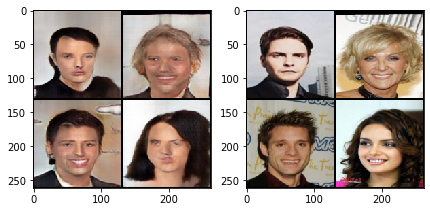

[0/2][1100/2111]	Loss_D: 1.2963	Loss_Dec: 2.7224	Loss_Enc: 29454.9844	D(x): 0.3845	D(G(z)): 0.2950
[0/2][1200/2111]	Loss_D: 1.2935	Loss_Dec: 2.7318	Loss_Enc: 29431.7932	D(x): 0.3680	D(G(z)): 0.2924
[0/2][1300/2111]	Loss_D: 1.2899	Loss_Dec: 2.7410	Loss_Enc: 29509.5978	D(x): 0.4009	D(G(z)): 0.2836
[0/2][1400/2111]	Loss_D: 1.2882	Loss_Dec: 2.7444	Loss_Enc: 29094.4959	D(x): 0.3579	D(G(z)): 0.2705
[0/2][1500/2111]	Loss_D: 1.2873	Loss_Dec: 2.7458	Loss_Enc: 29397.4529	D(x): 0.4100	D(G(z)): 0.3079
[0/2][1600/2111]	Loss_D: 1.2852	Loss_Dec: 2.7484	Loss_Enc: 29705.7905	D(x): 0.3066	D(G(z)): 0.3099
[0/2][1700/2111]	Loss_D: 1.2839	Loss_Dec: 2.7489	Loss_Enc: 29758.1819	D(x): 0.4528	D(G(z)): 0.1737
[0/2][1800/2111]	Loss_D: 1.2819	Loss_Dec: 2.7512	Loss_Enc: 29551.2985	D(x): 0.3628	D(G(z)): 0.3112
[0/2][1900/2111]	Loss_D: 1.2792	Loss_Dec: 2.7547	Loss_Enc: 29624.4206	D(x): 0.5721	D(G(z)): 0.2147
[0/2][2000/2111]	Loss_D: 1.2770	Loss_Dec: 2.7540	Loss_Enc: 29619.2849	D(x): 0.4937	D(G(z)): 0.2285


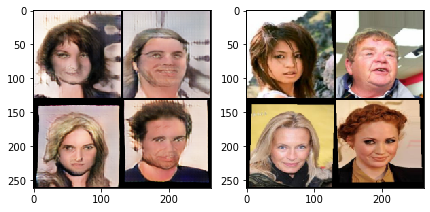

[0/2][2100/2111]	Loss_D: 1.2746	Loss_Dec: 2.7552	Loss_Enc: 29644.1461	D(x): 0.3573	D(G(z)): 0.2569


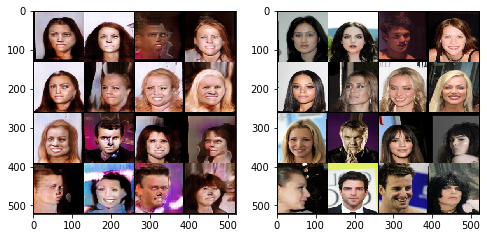

[1/2][0/2111]	Loss_D: 1.6852	Loss_Dec: 2.4333	Loss_Enc: 35527.6016	D(x): 0.3080	D(G(z)): 0.3241
[1/2][100/2111]	Loss_D: 1.2454	Loss_Dec: 2.7487	Loss_Enc: 27376.0017	D(x): 0.3847	D(G(z)): 0.2613
[1/2][200/2111]	Loss_D: 1.2509	Loss_Dec: 2.7414	Loss_Enc: 27410.5528	D(x): 0.4438	D(G(z)): 0.2366
[1/2][300/2111]	Loss_D: 1.2470	Loss_Dec: 2.7354	Loss_Enc: 27370.8415	D(x): 0.4661	D(G(z)): 0.2532
[1/2][400/2111]	Loss_D: 1.2473	Loss_Dec: 2.7355	Loss_Enc: 27267.3811	D(x): 0.4125	D(G(z)): 0.2377
[1/2][500/2111]	Loss_D: 1.2432	Loss_Dec: 2.7352	Loss_Enc: 27151.4128	D(x): 0.4587	D(G(z)): 0.2481
[1/2][600/2111]	Loss_D: 1.2432	Loss_Dec: 2.7338	Loss_Enc: 27056.1567	D(x): 0.4105	D(G(z)): 0.2423
[1/2][700/2111]	Loss_D: 1.2434	Loss_Dec: 2.7305	Loss_Enc: 27103.9010	D(x): 0.4318	D(G(z)): 0.2556
[1/2][800/2111]	Loss_D: 1.2431	Loss_Dec: 2.7292	Loss_Enc: 27364.5579	D(x): 0.4519	D(G(z)): 0.2384
[1/2][900/2111]	Loss_D: 1.2423	Loss_Dec: 2.7299	Loss_Enc: 27541.1012	D(x): 0.4159	D(G(z)): 0.2588
[1/2][1000/2111]	Loss_

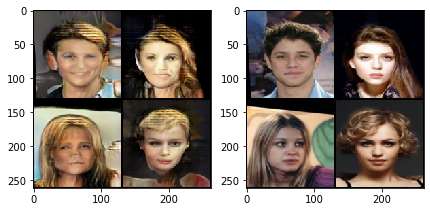

[1/2][1100/2111]	Loss_D: 1.2405	Loss_Dec: 2.7301	Loss_Enc: 27294.7282	D(x): 0.4574	D(G(z)): 0.2483
[1/2][1200/2111]	Loss_D: 1.2403	Loss_Dec: 2.7299	Loss_Enc: 27219.7206	D(x): 0.4169	D(G(z)): 0.2753
[1/2][1300/2111]	Loss_D: 1.2397	Loss_Dec: 2.7306	Loss_Enc: 27267.0003	D(x): 0.4997	D(G(z)): 0.2138
[1/2][1400/2111]	Loss_D: 1.2382	Loss_Dec: 2.7313	Loss_Enc: 27486.2542	D(x): 0.3968	D(G(z)): 0.2615
[1/2][1500/2111]	Loss_D: 1.2384	Loss_Dec: 2.7270	Loss_Enc: 27750.4583	D(x): 0.4408	D(G(z)): 0.2439
[1/2][1600/2111]	Loss_D: 1.2379	Loss_Dec: 2.7266	Loss_Enc: 28037.6423	D(x): 0.4233	D(G(z)): 0.2627
[1/2][1700/2111]	Loss_D: 1.2372	Loss_Dec: 2.7260	Loss_Enc: 28143.2742	D(x): 0.4622	D(G(z)): 0.2371
[1/2][1800/2111]	Loss_D: 1.2371	Loss_Dec: 2.7243	Loss_Enc: 28258.8058	D(x): 0.3771	D(G(z)): 0.2514
[1/2][1900/2111]	Loss_D: 1.2370	Loss_Dec: 2.7245	Loss_Enc: 28293.5994	D(x): 0.4053	D(G(z)): 0.2657
[1/2][2000/2111]	Loss_D: 1.2376	Loss_Dec: 2.7223	Loss_Enc: 28269.8179	D(x): 0.3630	D(G(z)): 0.3051


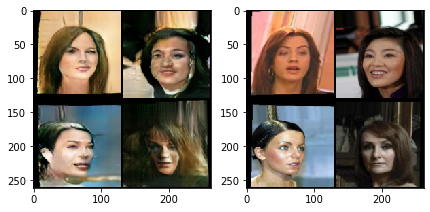

[1/2][2100/2111]	Loss_D: 1.2370	Loss_Dec: 2.7220	Loss_Enc: 28283.0379	D(x): 0.4503	D(G(z)): 0.2569


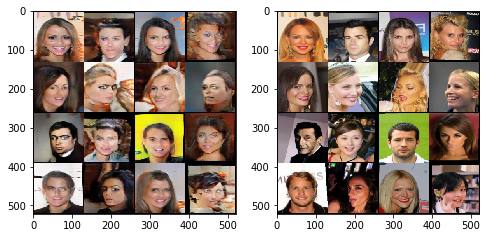

Copying file://./net.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/301.1 MiB.                                    


In [0]:
train(net, optimizer_discriminator, optimizer_decoder,  optimizer_encoder, n_epochs=2, train_loader=train_loader)

[0/2][0/3074]	Loss_D: 1.2847	Loss_Dec: 2.5002	Loss_Enc: 21902.4277	D(x): 0.3979	D(G(z)): 0.2568
[0/2][100/3074]	Loss_D: 1.2731	Loss_Dec: 2.6760	Loss_Enc: 30219.4100	D(x): 0.4262	D(G(z)): 0.2538
[0/2][200/3074]	Loss_D: 1.2661	Loss_Dec: 2.6602	Loss_Enc: 27035.6086	D(x): 0.4837	D(G(z)): 0.2361
[0/2][300/3074]	Loss_D: 1.2651	Loss_Dec: 2.6489	Loss_Enc: 25774.2512	D(x): 0.3497	D(G(z)): 0.2771
[0/2][400/3074]	Loss_D: 1.2631	Loss_Dec: 2.6450	Loss_Enc: 24925.7923	D(x): 0.3906	D(G(z)): 0.2554
[0/2][500/3074]	Loss_D: 1.2580	Loss_Dec: 2.6476	Loss_Enc: 24489.2230	D(x): 0.4330	D(G(z)): 0.2493
[0/2][600/3074]	Loss_D: 1.2570	Loss_Dec: 2.6490	Loss_Enc: 24346.1163	D(x): 0.3931	D(G(z)): 0.2586
[0/2][700/3074]	Loss_D: 1.2563	Loss_Dec: 2.6512	Loss_Enc: 24196.1734	D(x): 0.4070	D(G(z)): 0.2624
[0/2][800/3074]	Loss_D: 1.2561	Loss_Dec: 2.6508	Loss_Enc: 24046.9988	D(x): 0.4447	D(G(z)): 0.2376
[0/2][900/3074]	Loss_D: 1.2547	Loss_Dec: 2.6527	Loss_Enc: 24189.2412	D(x): 0.3832	D(G(z)): 0.2577
[0/2][1000/3074]	Loss_

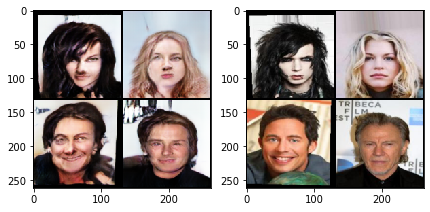

[0/2][1100/3074]	Loss_D: 1.2538	Loss_Dec: 2.6529	Loss_Enc: 24124.2929	D(x): 0.4111	D(G(z)): 0.2488
[0/2][1200/3074]	Loss_D: 1.2527	Loss_Dec: 2.6557	Loss_Enc: 24137.1102	D(x): 0.4560	D(G(z)): 0.2298
[0/2][1300/3074]	Loss_D: 1.2524	Loss_Dec: 2.6558	Loss_Enc: 24148.5618	D(x): 0.3825	D(G(z)): 0.2742
[0/2][1400/3074]	Loss_D: 1.2502	Loss_Dec: 2.6570	Loss_Enc: 24248.4658	D(x): 0.3834	D(G(z)): 0.2544
[0/2][1500/3074]	Loss_D: 1.2493	Loss_Dec: 2.6574	Loss_Enc: 24326.5299	D(x): 0.4079	D(G(z)): 0.2535
[0/2][1600/3074]	Loss_D: 1.2485	Loss_Dec: 2.6563	Loss_Enc: 24383.6599	D(x): 0.3826	D(G(z)): 0.2887
[0/2][1700/3074]	Loss_D: 1.2474	Loss_Dec: 2.6572	Loss_Enc: 24454.3193	D(x): 0.4468	D(G(z)): 0.2384
[0/2][1800/3074]	Loss_D: 1.2468	Loss_Dec: 2.6566	Loss_Enc: 24494.7084	D(x): 0.4207	D(G(z)): 0.2584
[0/2][1900/3074]	Loss_D: 1.2478	Loss_Dec: 2.6548	Loss_Enc: 24540.8312	D(x): 0.4288	D(G(z)): 0.2615
[0/2][2000/3074]	Loss_D: 1.2481	Loss_Dec: 2.6535	Loss_Enc: 24589.9182	D(x): 0.3699	D(G(z)): 0.2705


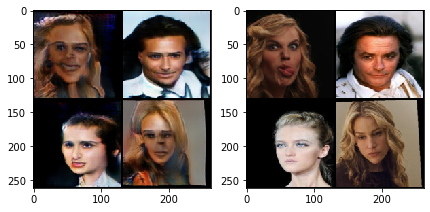

[0/2][2100/3074]	Loss_D: 1.2477	Loss_Dec: 2.6529	Loss_Enc: 24629.5799	D(x): 0.4760	D(G(z)): 0.2337
[0/2][2200/3074]	Loss_D: 1.2467	Loss_Dec: 2.6540	Loss_Enc: 24722.2421	D(x): 0.3510	D(G(z)): 0.2772
[0/2][2300/3074]	Loss_D: 1.2468	Loss_Dec: 2.6536	Loss_Enc: 24828.7037	D(x): 0.3761	D(G(z)): 0.2840
[0/2][2400/3074]	Loss_D: 1.2464	Loss_Dec: 2.6533	Loss_Enc: 24948.9349	D(x): 0.4571	D(G(z)): 0.2442
[0/2][2500/3074]	Loss_D: 1.2458	Loss_Dec: 2.6546	Loss_Enc: 25010.6999	D(x): 0.3832	D(G(z)): 0.2914
[0/2][2600/3074]	Loss_D: 1.2453	Loss_Dec: 2.6552	Loss_Enc: 25074.4769	D(x): 0.4049	D(G(z)): 0.2502
[0/2][2700/3074]	Loss_D: 1.2453	Loss_Dec: 2.6542	Loss_Enc: 25113.6945	D(x): 0.4059	D(G(z)): 0.2405
[0/2][2800/3074]	Loss_D: 1.2455	Loss_Dec: 2.6532	Loss_Enc: 25154.0505	D(x): 0.4592	D(G(z)): 0.2458
[0/2][2900/3074]	Loss_D: 1.2460	Loss_Dec: 2.6528	Loss_Enc: 25185.2181	D(x): 0.4019	D(G(z)): 0.2484
[0/2][3000/3074]	Loss_D: 1.2460	Loss_Dec: 2.6521	Loss_Enc: 25222.4080	D(x): 0.4327	D(G(z)): 0.2433


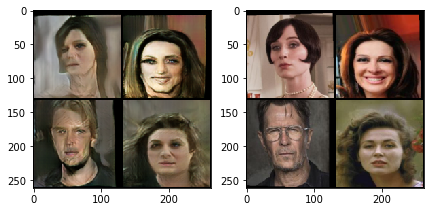

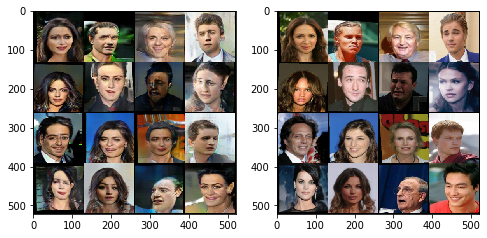

[1/2][0/3074]	Loss_D: 1.2029	Loss_Dec: 2.6779	Loss_Enc: 24320.5430	D(x): 0.4260	D(G(z)): 0.2552
[1/2][100/3074]	Loss_D: 1.2447	Loss_Dec: 2.6392	Loss_Enc: 26266.2971	D(x): 0.3822	D(G(z)): 0.2657
[1/2][200/3074]	Loss_D: 1.2480	Loss_Dec: 2.6365	Loss_Enc: 26148.5181	D(x): 0.3849	D(G(z)): 0.2605
[1/2][300/3074]	Loss_D: 1.2516	Loss_Dec: 2.6379	Loss_Enc: 26324.6697	D(x): 0.3939	D(G(z)): 0.2788
[1/2][400/3074]	Loss_D: 1.2537	Loss_Dec: 2.6324	Loss_Enc: 26263.2426	D(x): 0.4059	D(G(z)): 0.2638
[1/2][500/3074]	Loss_D: 1.2542	Loss_Dec: 2.6308	Loss_Enc: 26240.4794	D(x): 0.4350	D(G(z)): 0.2565
[1/2][600/3074]	Loss_D: 1.2549	Loss_Dec: 2.6269	Loss_Enc: 26253.2546	D(x): 0.3794	D(G(z)): 0.2789
[1/2][700/3074]	Loss_D: 1.2567	Loss_Dec: 2.6256	Loss_Enc: 26200.0213	D(x): 0.3868	D(G(z)): 0.2619
[1/2][800/3074]	Loss_D: 1.2587	Loss_Dec: 2.6227	Loss_Enc: 26186.7656	D(x): 0.4236	D(G(z)): 0.2441
[1/2][900/3074]	Loss_D: 1.2591	Loss_Dec: 2.6217	Loss_Enc: 26137.9651	D(x): 0.4047	D(G(z)): 0.2428
[1/2][1000/3074]	Loss_

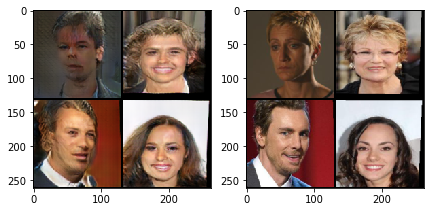

[1/2][1100/3074]	Loss_D: 1.2590	Loss_Dec: 2.6202	Loss_Enc: 26082.9573	D(x): 0.4123	D(G(z)): 0.2503
[1/2][1200/3074]	Loss_D: 1.2602	Loss_Dec: 2.6183	Loss_Enc: 26095.1642	D(x): 0.3948	D(G(z)): 0.2624
[1/2][1300/3074]	Loss_D: 1.2607	Loss_Dec: 2.6175	Loss_Enc: 26068.5611	D(x): 0.4195	D(G(z)): 0.2557
[1/2][1400/3074]	Loss_D: 1.2614	Loss_Dec: 2.6170	Loss_Enc: 26055.6449	D(x): 0.4105	D(G(z)): 0.2755
[1/2][1500/3074]	Loss_D: 1.2609	Loss_Dec: 2.6176	Loss_Enc: 26040.3540	D(x): 0.4102	D(G(z)): 0.2562
[1/2][1600/3074]	Loss_D: 1.2604	Loss_Dec: 2.6197	Loss_Enc: 26033.1366	D(x): 0.4152	D(G(z)): 0.2514
[1/2][1700/3074]	Loss_D: 1.2600	Loss_Dec: 2.6212	Loss_Enc: 26025.8424	D(x): 0.4091	D(G(z)): 0.2448
[1/2][1800/3074]	Loss_D: 1.2596	Loss_Dec: 2.6208	Loss_Enc: 26019.5675	D(x): 0.3831	D(G(z)): 0.2758
[1/2][1900/3074]	Loss_D: 1.2596	Loss_Dec: 2.6200	Loss_Enc: 25991.7521	D(x): 0.4179	D(G(z)): 0.2439
[1/2][2000/3074]	Loss_D: 1.2600	Loss_Dec: 2.6194	Loss_Enc: 25971.9954	D(x): 0.3908	D(G(z)): 0.2572


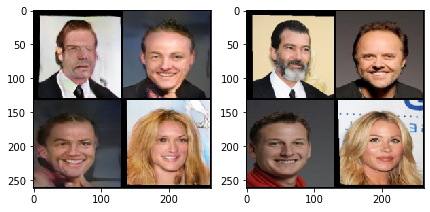

[1/2][2100/3074]	Loss_D: 1.2603	Loss_Dec: 2.6188	Loss_Enc: 25970.3578	D(x): 0.4010	D(G(z)): 0.2721
[1/2][2200/3074]	Loss_D: 1.2606	Loss_Dec: 2.6191	Loss_Enc: 25960.7105	D(x): 0.3941	D(G(z)): 0.2668
[1/2][2300/3074]	Loss_D: 1.2607	Loss_Dec: 2.6180	Loss_Enc: 25977.4434	D(x): 0.4009	D(G(z)): 0.2542
[1/2][2400/3074]	Loss_D: 1.2606	Loss_Dec: 2.6179	Loss_Enc: 25943.0752	D(x): 0.4207	D(G(z)): 0.2473
[1/2][2500/3074]	Loss_D: 1.2609	Loss_Dec: 2.6170	Loss_Enc: 25922.9919	D(x): 0.3870	D(G(z)): 0.2777
[1/2][2600/3074]	Loss_D: 1.2608	Loss_Dec: 2.6180	Loss_Enc: 25915.4061	D(x): 0.4051	D(G(z)): 0.2640
[1/2][2700/3074]	Loss_D: 1.2610	Loss_Dec: 2.6176	Loss_Enc: 25905.0099	D(x): 0.4263	D(G(z)): 0.2530
[1/2][2800/3074]	Loss_D: 1.2615	Loss_Dec: 2.6173	Loss_Enc: 25875.2793	D(x): 0.3936	D(G(z)): 0.2657
[1/2][2900/3074]	Loss_D: 1.2616	Loss_Dec: 2.6168	Loss_Enc: 25847.2307	D(x): 0.3997	D(G(z)): 0.2631
[1/2][3000/3074]	Loss_D: 1.2617	Loss_Dec: 2.6160	Loss_Enc: 25824.2356	D(x): 0.3744	D(G(z)): 0.2811


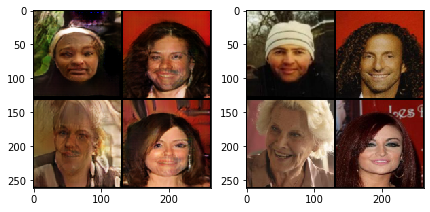

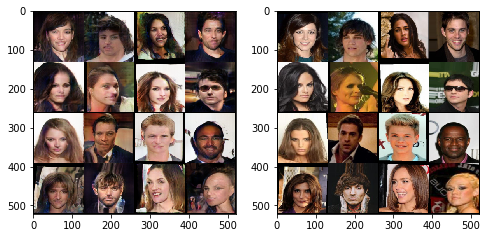

Copying file://./net.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/301.1 MiB.                                    


In [0]:
train(net, optimizer_discriminator, optimizer_decoder,  optimizer_encoder, n_epochs=2, train_loader=train_loader)

[0/2][0/3074]	Loss_D: 1.2914	Loss_Dec: 2.6255	Loss_Enc: 23580.3750	D(x): 0.3966	D(G(z)): 0.2600
[0/2][100/3074]	Loss_D: 1.3213	Loss_Dec: 2.6148	Loss_Enc: 30187.4347	D(x): 0.4108	D(G(z)): 0.2542
[0/2][200/3074]	Loss_D: 1.2980	Loss_Dec: 2.6275	Loss_Enc: 28113.1344	D(x): 0.3717	D(G(z)): 0.2825
[0/2][300/3074]	Loss_D: 1.2890	Loss_Dec: 2.6340	Loss_Enc: 27640.5678	D(x): 0.4634	D(G(z)): 0.2343
[0/2][400/3074]	Loss_D: 1.2836	Loss_Dec: 2.6404	Loss_Enc: 27280.5613	D(x): 0.4306	D(G(z)): 0.2357
[0/2][500/3074]	Loss_D: 1.2806	Loss_Dec: 2.6380	Loss_Enc: 27098.9189	D(x): 0.3936	D(G(z)): 0.2745
[0/2][600/3074]	Loss_D: 1.2796	Loss_Dec: 2.6374	Loss_Enc: 27135.9396	D(x): 0.4648	D(G(z)): 0.2352
[0/2][700/3074]	Loss_D: 1.2764	Loss_Dec: 2.6415	Loss_Enc: 27088.8245	D(x): 0.4029	D(G(z)): 0.2600
[0/2][800/3074]	Loss_D: 1.2745	Loss_Dec: 2.6437	Loss_Enc: 27038.2678	D(x): 0.4133	D(G(z)): 0.2729
[0/2][900/3074]	Loss_D: 1.2725	Loss_Dec: 2.6459	Loss_Enc: 26979.1172	D(x): 0.4092	D(G(z)): 0.2531
[0/2][1000/3074]	Loss_

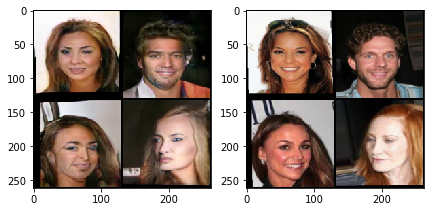

[0/2][1100/3074]	Loss_D: 1.2686	Loss_Dec: 2.6542	Loss_Enc: 26993.6592	D(x): 0.3869	D(G(z)): 0.2720
[0/2][1200/3074]	Loss_D: 1.2675	Loss_Dec: 2.6563	Loss_Enc: 27038.3353	D(x): 0.4251	D(G(z)): 0.2576
[0/2][1300/3074]	Loss_D: 1.2670	Loss_Dec: 2.6583	Loss_Enc: 27203.5864	D(x): 0.4544	D(G(z)): 0.2495
[0/2][1400/3074]	Loss_D: 1.2657	Loss_Dec: 2.6584	Loss_Enc: 27236.2873	D(x): 0.4910	D(G(z)): 0.2182
[0/2][1500/3074]	Loss_D: 1.2654	Loss_Dec: 2.6580	Loss_Enc: 27261.0707	D(x): 0.4080	D(G(z)): 0.2716
[0/2][1600/3074]	Loss_D: 1.2640	Loss_Dec: 2.6592	Loss_Enc: 27280.1167	D(x): 0.5098	D(G(z)): 0.2157
[0/2][1700/3074]	Loss_D: 1.2633	Loss_Dec: 2.6600	Loss_Enc: 27294.0572	D(x): 0.4151	D(G(z)): 0.2459
[0/2][1800/3074]	Loss_D: 1.2627	Loss_Dec: 2.6609	Loss_Enc: 27362.0253	D(x): 0.4381	D(G(z)): 0.2468
[0/2][1900/3074]	Loss_D: 1.2627	Loss_Dec: 2.6606	Loss_Enc: 27384.8287	D(x): 0.3808	D(G(z)): 0.2685
[0/2][2000/3074]	Loss_D: 1.2616	Loss_Dec: 2.6612	Loss_Enc: 27434.3596	D(x): 0.4073	D(G(z)): 0.2712


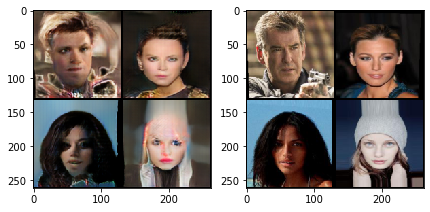

[0/2][2100/3074]	Loss_D: 1.2611	Loss_Dec: 2.6609	Loss_Enc: 27511.6886	D(x): 0.4166	D(G(z)): 0.2559
[0/2][2200/3074]	Loss_D: 1.2605	Loss_Dec: 2.6606	Loss_Enc: 27548.4288	D(x): 0.4429	D(G(z)): 0.2565
[0/2][2300/3074]	Loss_D: 1.2598	Loss_Dec: 2.6626	Loss_Enc: 27562.9291	D(x): 0.3909	D(G(z)): 0.2535
[0/2][2400/3074]	Loss_D: 1.2599	Loss_Dec: 2.6619	Loss_Enc: 27581.9752	D(x): 0.3911	D(G(z)): 0.2712
[0/2][2500/3074]	Loss_D: 1.2603	Loss_Dec: 2.6613	Loss_Enc: 27585.1316	D(x): 0.4208	D(G(z)): 0.2544
[0/2][2600/3074]	Loss_D: 1.2600	Loss_Dec: 2.6606	Loss_Enc: 27591.9091	D(x): 0.4057	D(G(z)): 0.2750
[0/2][2700/3074]	Loss_D: 1.2598	Loss_Dec: 2.6605	Loss_Enc: 27621.5963	D(x): 0.4182	D(G(z)): 0.2517
[0/2][2800/3074]	Loss_D: 1.2594	Loss_Dec: 2.6621	Loss_Enc: 27651.7195	D(x): 0.3752	D(G(z)): 0.2849
[0/2][2900/3074]	Loss_D: 1.2594	Loss_Dec: 2.6625	Loss_Enc: 27673.8720	D(x): 0.4254	D(G(z)): 0.2579
[0/2][3000/3074]	Loss_D: 1.2591	Loss_Dec: 2.6624	Loss_Enc: 27695.6075	D(x): 0.4264	D(G(z)): 0.2500


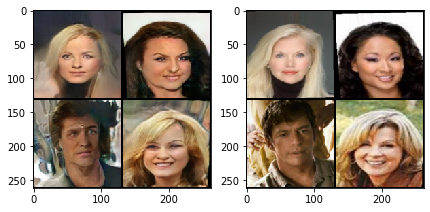

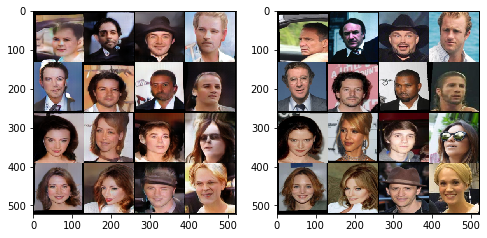

[1/2][0/3074]	Loss_D: 1.2459	Loss_Dec: 2.7259	Loss_Enc: 27198.5352	D(x): 0.4232	D(G(z)): 0.2470
[1/2][100/3074]	Loss_D: 1.2591	Loss_Dec: 2.6307	Loss_Enc: 28141.9513	D(x): 0.4113	D(G(z)): 0.2647
[1/2][200/3074]	Loss_D: 1.2559	Loss_Dec: 2.6431	Loss_Enc: 27976.9136	D(x): 0.4224	D(G(z)): 0.2452
[1/2][300/3074]	Loss_D: 1.2555	Loss_Dec: 2.6521	Loss_Enc: 27931.2587	D(x): 0.4207	D(G(z)): 0.2551


In [0]:
train(net, optimizer_discriminator, optimizer_decoder,  optimizer_encoder, n_epochs=2, train_loader=train_loader)

In [0]:
train(net, optimizer_discriminator, optimizer_decoder,  optimizer_encoder, n_epochs=3, train_loader=train_loader)

In [0]:
torch.save(net.state_dict(), "net.pt")
!gsutil cp ./net.pt gs://{bucket_name}/net.pt 

Copying file://./net.pt [Content-Type=application/octet-stream]...
/
Operation completed over 1 objects/128.8 MiB.                                    


In [0]:
with torch.no_grad():
    net.eval()
    inputs, _ = next(iter(test_loader))
    inputs = inputs.cuda()
    
    fake = net(inputs)
    
    train_batch = inputs.shape[0]
    fake = (fake * 0.5) + 0.5
    decoded = fake[:train_batch]
    # out_layer_original = fake[train_batch:-train_batch]
    sampled = fake[train_batch:]
    
    fig, ax = plt.subplots(1, 3, figsize=(12,12))
    ax[0].imshow(np.transpose(vutils.make_grid(decoded.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[0].set_title("Non-Sampled")
    ax[1].imshow(np.transpose(vutils.make_grid(sampled.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[1].set_title("Sampled")
    ax[2].imshow(np.transpose(vutils.make_grid(inputs.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[2].set_title("Original")
    plt.show()   

# print("Code mean:", code.mean().item())
# print("Code max:", code.max().item())
# print("Code min:", code.min().item())
# print("Code var:", code.var().item())
# print()

# # print("SCode mean:", code_s.mean().item())
# # print("SCode max:", code_s.max().item())
# # print("SCode min:", code_s.min().item())
# # print("SCode var:", code_s.var().item())
# # print()

# print("Logvar mean:", logvar.mean().item())
# print("Logvar var:", logvar.var().item())
# print("Logvar Exp:", logvar.exp().mean().item())